### In order to run the code the training and testing files should be in the same folder as that of the notebook

#### The datasets can be downloaded from https://www.kaggle.com/c/mercari-price-suggestion-challenge/data 

#### Please download all the .zip files and extract all of them. (important)

#### All the unziped datasets should be in the folder 'project' along with this jupyter notebook.

##### Reference: 
        https://github.com/pjankiewicz/mercari-solution/raw/master/presentation/build/yandex.pdf
        https://www.youtube.com/watch?v=FlVJo7LbOzY : to understand the RNN multiple inputs architecture.
        http://adventuresinmachinelearning.com/word2vec-keras-tutorial/ : to understand the concept of Embedded Layers

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,  StandardScaler
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import os
print(os.listdir('../project'))

c:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


['.ipynb_checkpoints', 'EDA_Project.ipynb', 'myNNsubmission.csv', 'Project.ipynb', 'RNN process.pdf', 'sample_submission.csv', 'sample_submission.csv (1).7z', 'sample_submission.csv.7z', 'sample_submission_stg2.csv', 'sample_submission_stg2.csv.zip', 'test.tsv', 'test.tsv.7z', 'test_stg2.tsv', 'test_stg2.tsv.zip', 'train.tsv', 'train.tsv.7z', 'Untitled.ipynb', 'Untitled1.ipynb']


In [2]:
#Defining a function for root mean square logarithimic error
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [3]:
#LOAD DATA
print("Loading data...")
train = pd.read_table("../project/train.tsv")
test = pd.read_table("../project/test_stg2.tsv")
print(train.shape)
print(test.shape)

Loading data...
(1482535, 8)
(3460725, 7)


In [4]:
#HANDLE MISSING VALUES
print("Handling missing values...")
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

Handling missing values...
(1482535, 8)
(3460725, 7)


In [5]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [6]:
#Label Encoder function: Customized from Scikit-Learn library.  Instead of importing the LabelEncoder() from preprocessing 
#package of Scikit Learn Library, we have demostrated that classes can be written and customized as per our requirement.

from collections import defaultdict
import itertools
import array
import numpy as np
import scipy.sparse as sp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.fixes import sparse_min_max
from sklearn.utils import column_or_1d
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import unique_labels


class LabelEncoder1(BaseEstimator, TransformerMixin):
   
    def fit(self, y):
        y = column_or_1d(y, warn=True)  #Checks if the input parameter is 1d array
        self.classes_ = np.unique(y)    #Unique values of the array are returned
        return self

    def transform(self, y):
        check_is_fitted(self, 'classes_') # Checking if the instance is fitted or not.
        y = column_or_1d(y, warn=True)
        classes = np.unique(y) #Unique values of the array
        if len(np.intersect1d(classes, self.classes_)) < len(classes): #Intersect ID function to check the common values between 2 arrays
            diff = np.setdiff1d(classes, self.classes_) #Difference of two array values
            raise ValueError("y contains new labels: %s" % str(diff))
        return np.searchsorted(self.classes_, y) # Array of insertion points with the same shape as y in the sorted manner.

In [7]:
#PROCESS CATEGORICAL DATA, TRANSFORMING CATEGORY NAME DATA & BRAND NAME DATA TO NUMERIC DATA
print("Handling categorical variables...")
le = LabelEncoder1()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(3)

Handling categorical variables...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,864,6286,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,87,4660,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1320,5489,10.0,1,Adorable top with a hint of lace and a key hol...


In [8]:
#PROCESS TEXT: RAW, Tokenizing the text, Converting the text to sequence

print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

Text to seq process...


Using TensorFlow backend.


   Fitting tokenizer...
   Transforming text to seq...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,864,6286,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,87,4660,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1320,5489,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [9]:
#SEQUENCES VARIABLES ANALYSIS
#To find out the maximum unique worded item_descriptor
#To find out the maximum unique worded item_name
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


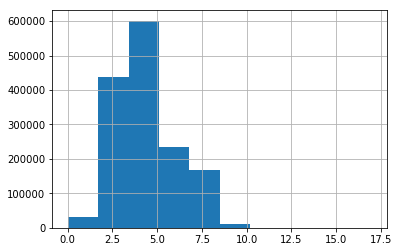

In [10]:
train.seq_name.apply(lambda x: len(x)).hist()

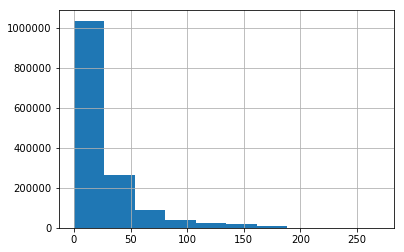

In [11]:
train.seq_item_description.apply(lambda x: len(x)).hist()

In [12]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths
#Gives the max length for each feature
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())
                  , np.max(train.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
#MAX_TEXT = len(tok_raw.word_index) + 1 #Tokenizer
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

c:\anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EDEC368780>]], dtype=object)

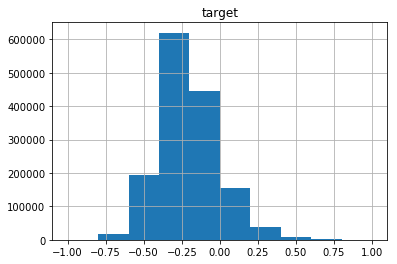

In [13]:
#SCALE target variable
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.reshape(-1,1))
pd.DataFrame(train.target).hist()

In [14]:
#EXTRACT DEVELOPTMENT TEST
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 11)
(14826, 11)


In [15]:
#KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'category_name': np.array(dataset.category_name)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [16]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate,LSTM, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    #Inputs 
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = LSTM(16, return_sequences = False) (emb_item_desc) #LSTM
    rnn_layer2 = LSTM(8, return_sequences = False) (emb_name)
    
    #rnn_layer1 = GRU(16) (emb_item_desc) #Gatedrecurrent unit
    #rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 75)           0                                            
__________________________________________________________________________________________________
name (Inpu

#### The following code below is going to fit the model on ~1.4 million training dataset.  As we can see below the rough estimate to fully train is 40 mins to 1.5 hours.  

#####  Run only if it is absolutely necessary 

In [17]:
#FITTING THE MODEL
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)


Train on 1467709 samples, validate on 14826 samples
Epoch 1/5
1467709/1467709 [==============================] - 816s 556us/step - loss: 0.0290 - mean_absolute_error: 0.1295 - rmsle_cust: 0.0155 - val_loss: 0.0180 - val_mean_absolute_error: 0.1017 - val_rmsle_cust: 0.0135
Epoch 2/5
1467709/1467709 [==============================] - 713s 486us/step - loss: 0.0178 - mean_absolute_error: 0.1011 - rmsle_cust: 0.0132 - val_loss: 0.0160 - val_mean_absolute_error: 0.0965 - val_rmsle_cust: 0.0125
Epoch 3/5
1467709/1467709 [==============================] - 690s 470us/step - loss: 0.0158 - mean_absolute_error: 0.0952 - rmsle_cust: 0.0125 - val_loss: 0.0153 - val_mean_absolute_error: 0.0938 - val_rmsle_cust: 0.0123
Epoch 4/5
1467709/1467709 [==============================] - 664s 453us/step - loss: 0.0149 - mean_absolute_error: 0.0924 - rmsle_cust: 0.0121 - val_loss: 0.0151 - val_mean_absolute_error: 0.0931 - val_rmsle_cust: 0.0122
Epoch 5/5
1467709/1467709 [==============================] - 683

In [18]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)-1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.4670984015832483


#### The Kaggle competition winner had a RMSLE score of 0.37 and our RMSLE score was 0.46.

##### The following can be implemented to improve the score:

- Instead of LSTM, GRU can be tested
- Instead of RNN, CNN could be tried.
- Different combinations of embedding layers can be tested.
- Play around with different activation functions.

In [19]:
#CREATE PREDICTIONS
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

c:\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


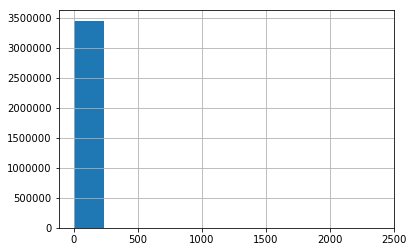

In [20]:
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()